# Continuación de la pregunta 4 lab 3

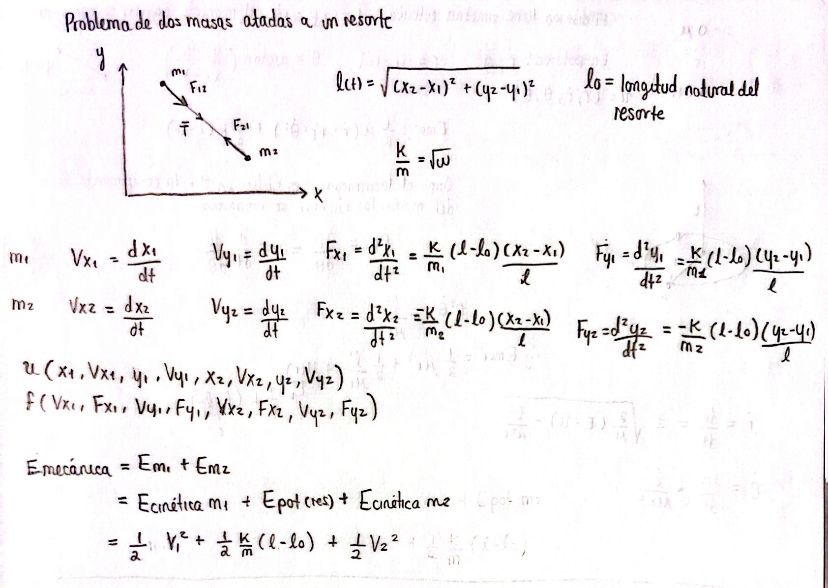

In [29]:
import numpy as np

In [30]:
#condiciones iniciales 
x0_1=0.7
y0_1=0
x0_2=-0.7
y0_2=0

v0x_1=0
v0y_1=0.1
v0x_2=0
v0y_2=-0.1

#arreglo que contenga las condiciones iniciales
u0 = np.array([x0_1,v0x_1,y0_1,v0y_1,x0_2,v0x_2,y0_2,v0y_2])

#parametros del sistema resorte
w = 1

l0 = 1

#arreglo que contenga el tiempo con un deltat (h)
tstop = 20
h = 1/100
t=np.arange(0.,tstop+h,h)

In [31]:
#funcion que contiene las fuerzas del resorte
def resorte(u,t,w,l0):
    #l es la longitud del resorte en un t
    l=np.sqrt((u[4]-u[0])**2+(u[6]-u[2])**2)
    deriv = np.array([u[1],(w**2)*(l-l0)*(u[4]-u[0])/l,u[3],(w**2)*(l-l0)*(u[6]-u[2])/l,u[5],-(w**2)*(l-l0)*(u[4]-u[0])/l,u[7],-(w**2)*(l-l0)*(u[6]-u[2])/l])
    return deriv

In [32]:
#método de solución de la ODE: Runge-Kutta de cuarto orden
def runge_kutta_4to(f_user, u0, t, *args):

    n = t.size
    neq = u0.size
    u = np.zeros((n, neq))

    u[0] = u0
    
    dt = t[1]-t[0]
    
    for i in range(n-1):
        k1 = f_user(u[i], t[i],*args)
        k2 = f_user(u[i]+(1/2)*k1*dt, t[i+1]+ (1/2)*dt,*args )
        k3 = f_user(u[i]+(1/2)*k2*dt, t[i+1]+ (1/2)*dt,*args )
        k4 = f_user(u[i]+ k3*dt, t[i+1]+ dt,*args)
        u[i+1] = u[i] + (1/6)*dt*(k1+2*k2+2*k3+k4)
    return u

In [33]:
#Método de solución de la ODE: Bulrisch Stoer Modifciado

#Primero definimos la función que nos calcula el resultado final a un dt anterior del fin del intervalo.

def MedioModificado(f_user, U0, t, *args):
    # aquí el método de punto medio nos da el resultado final a un dt anterior del fin
    # del intervalo. Similar a los otros métodos estudiados
    n = t.size
    neq = U0.size
    u = np.zeros((n, neq))

    u[0] = U0
    dt = t[1]-t[0]
    
    sol1 = u[0] + 0.5*dt*f_user(U0,t[0],*args)
    u[1] = u[0] + dt*f_user(sol1,t[0]+0.5*dt,*args)    
    
    for i in range(1,n-1):
        sol1 = sol1 + dt*f_user(u[i],t[i],*args)
        u[i+1] = u[i] + dt*f_user(sol1,t[i]+0.5*dt,*args)
        
    u[n-1] = 0.5*(u[n-1]+sol1+0.5*dt*f_user(u[n-1],t[n-1],*args))
    return u

#Definimos la función que calcula las derivadas

def BulirschStoer(f_user, z0, a, b, tol, *args):
    #Las filas de los resultados R lo almacenamos en dos arreglos Rprev y R
    #Calculo de R_1,1. Medio Modificado pero donde sale el último punto del intervalo.
    H = b-a
    tol = H*tol
    n = 1
    t = np.array([a,b])
    dimz = z0.size
    z = MedioModificado(f_user, z0, t, *args)
    Rprev = np.zeros((1,dimz))
    Rprev[0]=z[-1]
    while True:
        n += 1
        # h = H/n
        t= np.linspace(a,b,n+1)
        z = MedioModificado(f_user, z0, t, *args)
        R = np.zeros((n,dimz))
        R[0]=z[-1]
        for l in range(1,n):
            epsilon = (R[l-1]-Rprev[l-1])/((n/(n-1))**(2*l)-1)
            R[l] = R[l-1] + epsilon
        #Como definimos el error: solamente las posiciones
        error = np.sqrt((np.take(epsilon,range(0,dimz,2))**2).sum())
        if error <= tol:
            break
        else:
            Rprev = np.copy(R)
    return R[n-1]    

#Función que calcula las fuerzas para cada t+h

def BSmultiple(f_user,U0,t,tol,*args):
    nt = t.size
    dimU=U0.size
    u=np.zeros((nt,dimU))
    u[0]=U0
    H=t[1]-t[0]
    j=0
    for j,t in enumerate(t[:nt-1]):
        U0=u[j]
        u[j+1]=BulirschStoer(f_user,U0,t,t+H,tol,*args)
    return u

In [34]:
#Función que calcula la energía mecánica del sistema dado el arreglo de coordenadas y velocidades
def Emec(u,w,l0):
    l=np.sqrt((u[:,4]-u[:,0])**2+(u[:,6]-u[:,2])**2)
    r1=(u[:,1]**2+u[:,3]**2)
    r2=(u[:,5]**2+u[:,7]**2)
    K=(1/2)*r1+(1/2)*r2
    U=(1/2)*(w)*((l-l0)**2)
    E=K+U
    return E,K,U

In [35]:
u = runge_kutta_4to(resorte,u0,t,w,l0)
x1 = u[:,0]
x2 = u[:,4]
y1 = u[:,2]
y2 = u[:,6]



E1,K,U = Emec(u,w,l0)

In [36]:
#Cambio a polares
angulo= np.arctan((y2-y1)/(x2-x1))
r= np.sqrt((x2-x1)**2+(y2-y1)**2)

In [37]:
#función que calcula la velocidad en el punto medio dados los arreglos de las coordenadas y el tiempo
def Vcm(u):
    Velcmx = (u[:,1]+u[:,5])/2
    Velcmy = (u[:,3]+u[:,7])/2
    
    return Velcmx,Velcmy

In [38]:
def momento_angular(u):
    r = (u[:,0]-u[:,4],u[:,2]-u[:,6])
    V = (u[:,1]-u[:,5],u[:,3]-u[:,7])   
    momento_angular = np.cross(r,V,axis=0)
    return momento_angular

L=momento_angular(u)

In [39]:
ucm=runge_kutta_4to(resorte,u0,t,w,l0)
Velcmx, Velcmy= Vcm(ucm)

In [40]:
#Gráficas

import matplotlib.pyplot as plt

# Análisis dinámico utilizando Runge Kutta 4to Orden

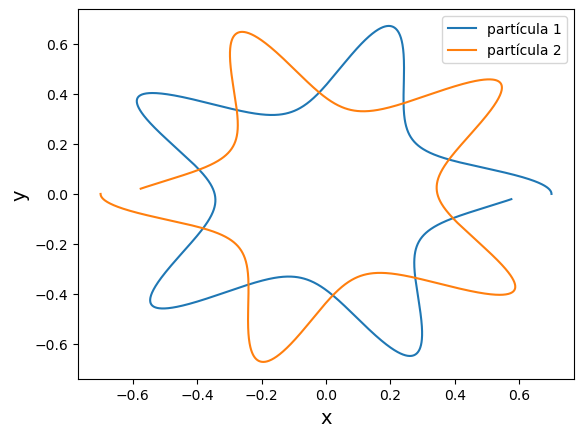

In [41]:
#Gráfcia de las trayectorias de las masas
plt.plot(x1,y1, label = "partícula 1")
plt.plot(x2,y2, label = "partícula 2")
plt.xlabel('x',fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(loc = 'best')
plt.show()

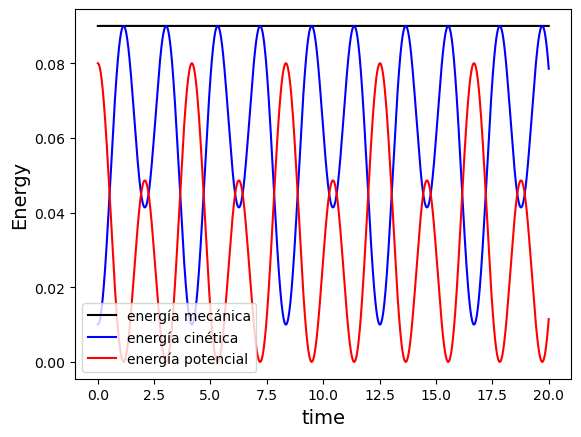

In [42]:
#Gráfcia de las energias cinética, potencial y mecánica

plt.plot(t,E1, color ='black', label = "energía mecánica")
plt.plot(t,K,  color='blue',label = "energía cinética")
plt.plot(t,U,  color='red',label = "energía potencial")

plt.xlabel('time',fontsize=14)
plt.ylabel('Energy', fontsize=14)


plt.legend(loc = 'best')
plt.show()

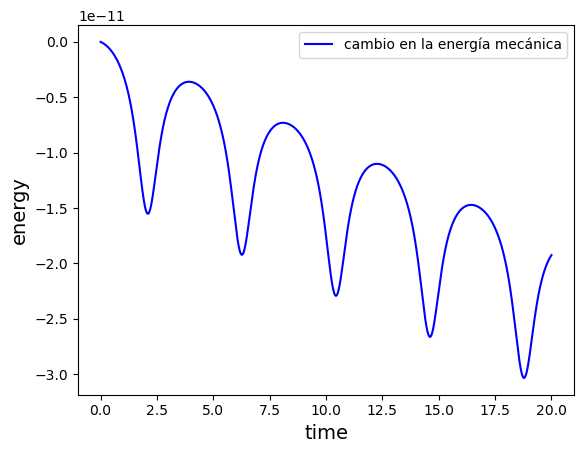

In [43]:
#Gráfcia del cambio en la energía mecánica en el tiempo
plt.plot(t,E1-E1[0], color='blue', label= 'cambio en la energía mecánica')

plt.xlabel('time', fontsize=14)
plt.ylabel('energy', fontsize=14)
plt.legend(loc = 'best')
plt.show()

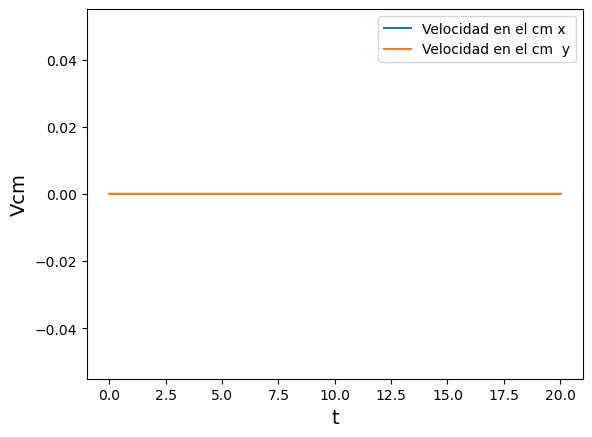

In [44]:
#Gráfcia de la velocidad media en el centro de masa en x y y 

plt.plot(t,Velcmx, label = "Velocidad en el cm x")
plt.plot(t,Velcmy, label = "Velocidad en el cm  y")
plt.xlabel('t',fontsize=14)
plt.ylabel('Vcm', fontsize=14)
plt.legend(loc = 'best')
plt.show()


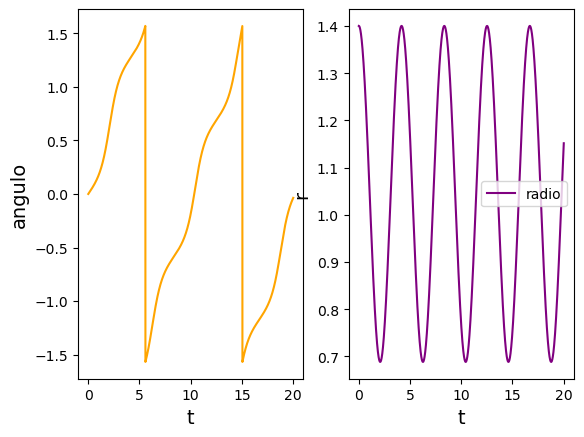

In [45]:
#Gráfcia del ángulo y el radio en función del tiempo
plt.subplot(1,2,1)
plt.plot(t,angulo, color='orange',label = "ángulo")
plt.xlabel('t',fontsize=14)
plt.ylabel('angulo', fontsize=14)
plt.subplot(1,2,2)
plt.plot(t,r, color='purple',label = "radio")
plt.xlabel('t',fontsize=14)
plt.ylabel('r', fontsize=14)
plt.legend(loc = 'best')
plt.show()

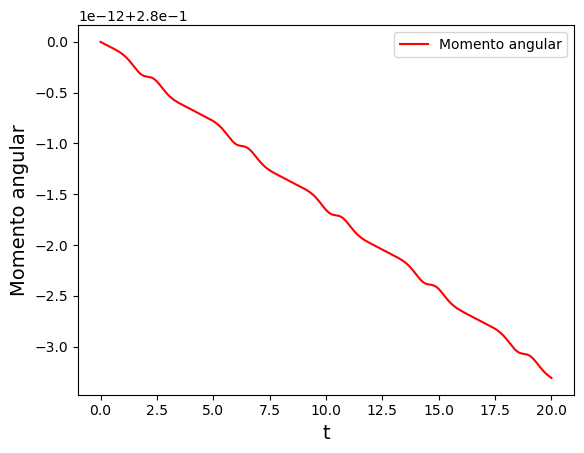

In [46]:
plt.plot(t,L,color='red',label = "Momento angular")
plt.xlabel('t',fontsize=14)
plt.ylabel('Momento angular', fontsize=14)
plt.legend(loc = 'best')
plt.show()

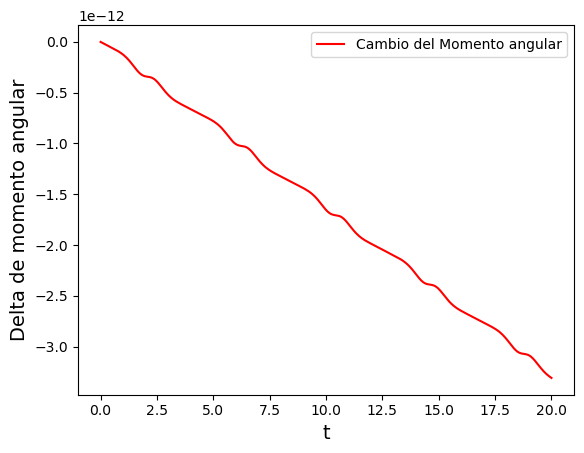

In [47]:
#Gráfica del cambio en el momento angular

plt.plot(t,L-L[0],color='red',label = "Cambio del Momento angular")
plt.xlabel('t',fontsize=14)
plt.ylabel('Delta de momento angular', fontsize=14)
plt.legend(loc = 'best')
plt.show()

# Potencial efectivo

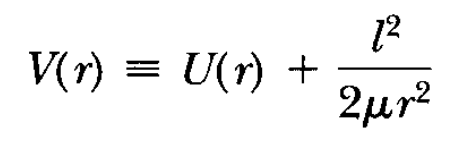


In [48]:
def Pot_ef(u,w,l0, momento_angular):
    l=np.sqrt((u[:,4]-u[:,0])**2+(u[:,6]-u[:,2])**2)
    U=(1/2)*(w)*((l-l0)**2)
    
    V= U+ (momento_angular**2)/(2*l**2)
    return V


In [49]:
m = runge_kutta_4to(resorte,u0,t,w,l0)

V=  Pot_ef(m,w,l0,L)
print(V)

[0.1        0.09998567 0.09994271 ... 0.04007815 0.04054337 0.04103556]


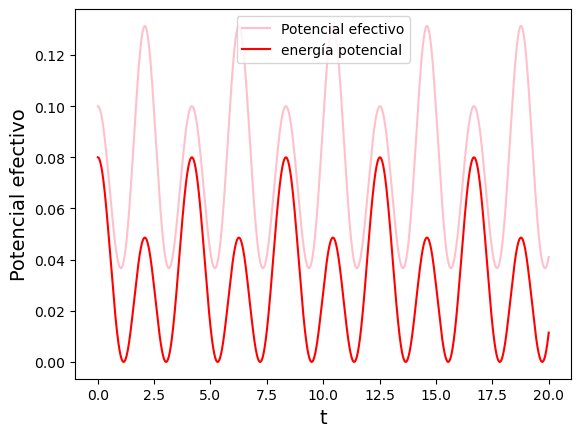

In [50]:
#Gráfica del potencial efectivo vs el potencial real

plt.plot(t,V,color='pink',label = "Potencial efectivo")
plt.plot(t,U,  color='red',label = "energía potencial")
plt.xlabel('t',fontsize=14)
plt.ylabel('Potencial efectivo', fontsize=14)
plt.legend(loc = 'best')
plt.show()

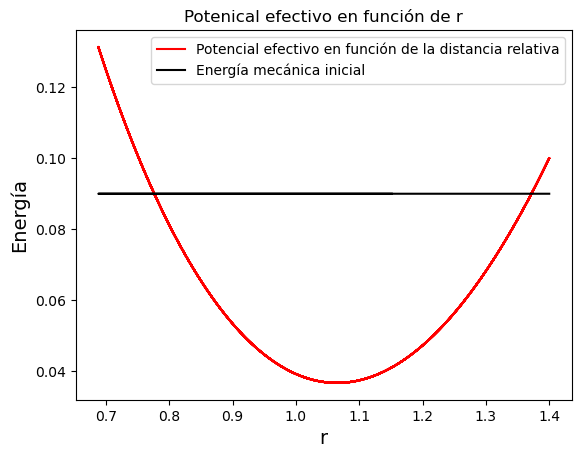

In [51]:
#Gráfica de la energía mecánica inicial y el potencial en función de r

plt.plot(r,V,color='red',label = "Potencial efectivo en función de la distancia relativa")
plt.plot(r,E1,color='black',label = "Energía mecánica inicial")

plt.xlabel('r',fontsize=14)
plt.ylabel('Energía', fontsize=14)
plt.legend(loc = 'best')
plt.title("Potenical efectivo en función de r")
plt.show()

# Preguntas sobre el análisis

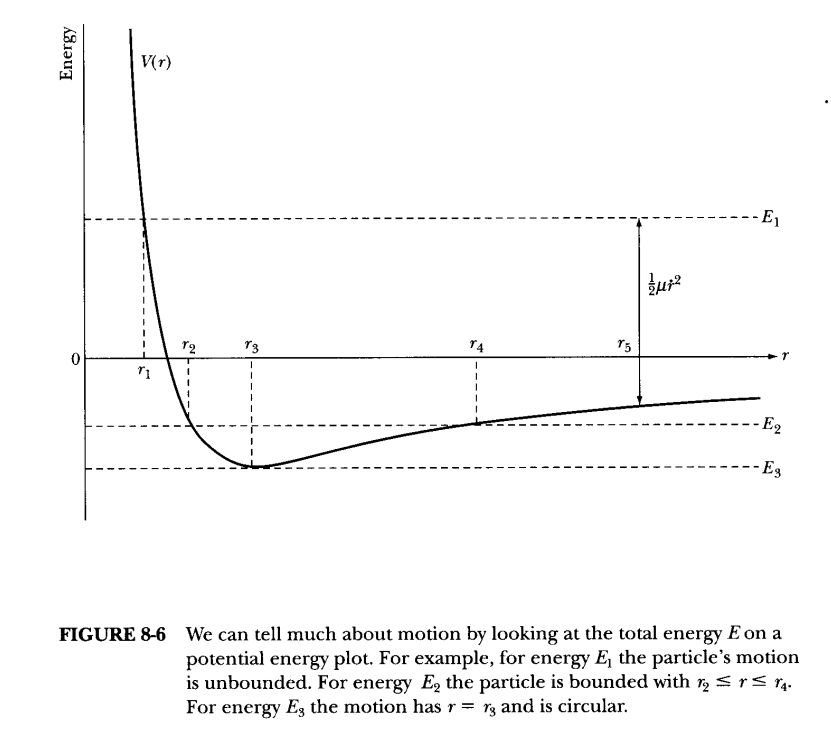

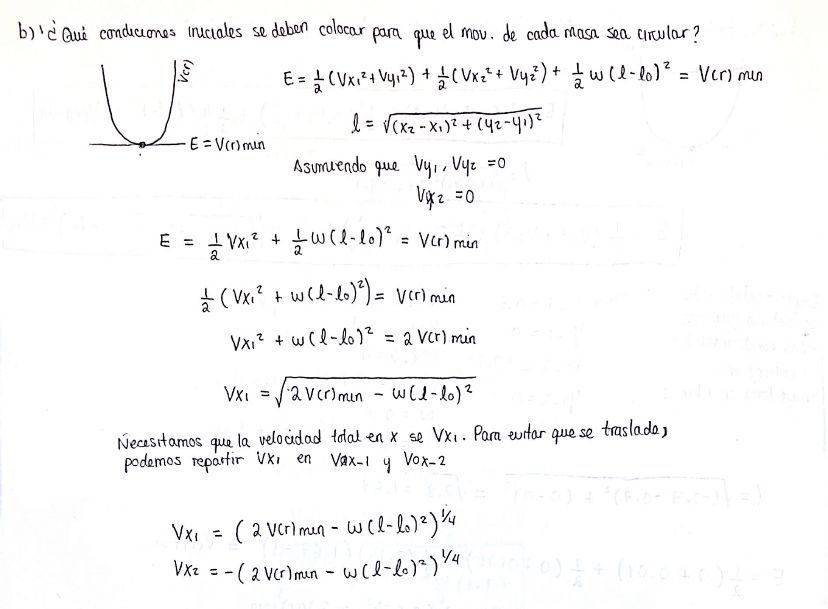

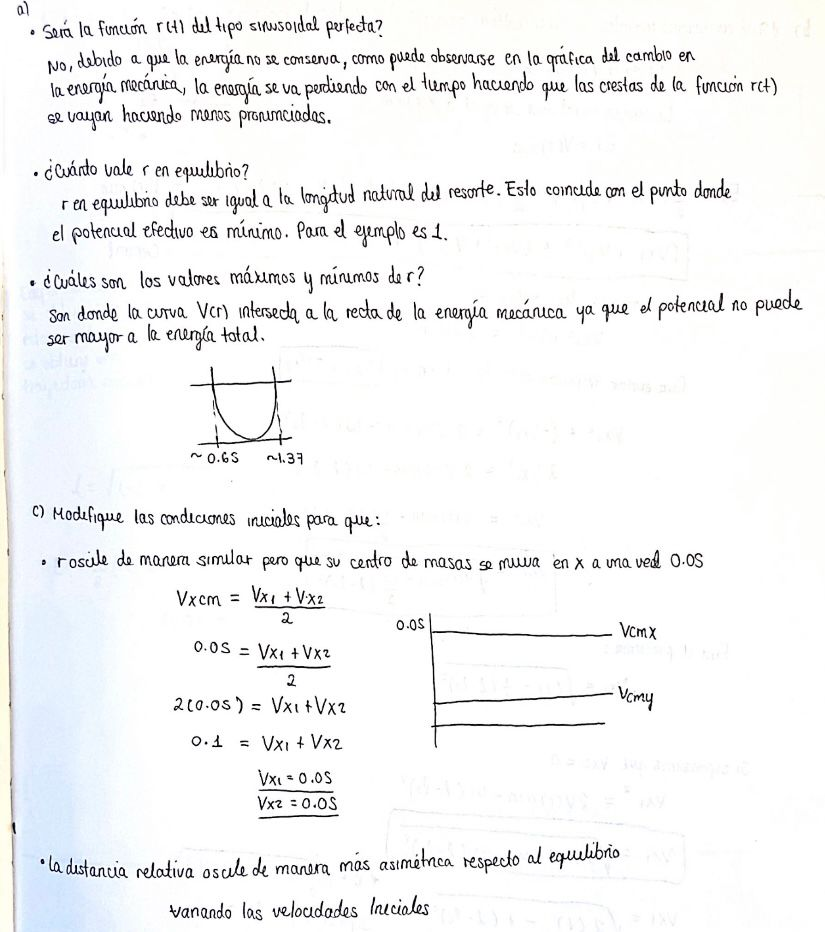

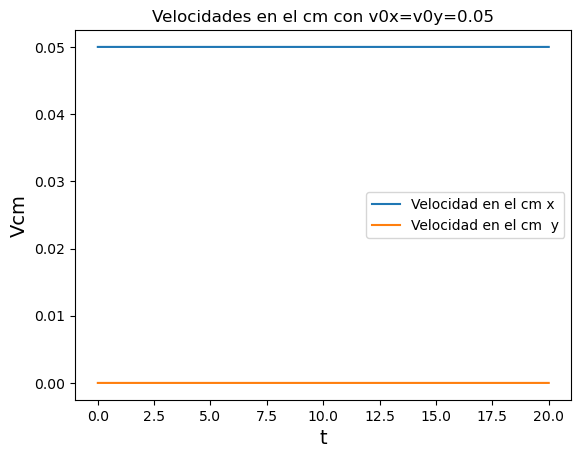

In [52]:
# Condiciones iniciales para que el centro de masas se mueva en x a velocidad de 0.05


#arreglo que contenga las condiciones iniciales: np.array([x0_1,v0x_1,y0_1,v0y_1,x0_2,v0x_2,y0_2,v0y_2])
u0m1 = np.array([0.7,0.05,0,0,-0.7,0.05,0,0])

#parametros del sistema resorte
w = 1

l0 = 1

#arreglo que contenga el tiempo con un deltat (h)
tstop = 20
h = 1/100
t=np.arange(0.,tstop+h,h)


ucm1=runge_kutta_4to(resorte,u0m1,t,w,l0)
Vcmxm1, Vcmym1= Vcm(ucm1)

# Gráfica de las velocidades en el centro de masa
plt.plot(t,Vcmxm1, label = "Velocidad en el cm x")
plt.plot(t,Vcmym1, label = "Velocidad en el cm  y")
plt.xlabel('t',fontsize=14)
plt.ylabel('Vcm', fontsize=14)
plt.legend(loc = 'best')
plt.title("Velocidades en el cm con v0x=v0y=0.05")
plt.show()



In [53]:
# Condiciones iniciales para que la trayectoria de las masas sea circular

#parametros del sistema resorte
w = 1
l0 = 1

#arreglo que contenga el tiempo con un deltat (h)
tstop = 20
h = 1/100
t=np.arange(0.,tstop+h,h)

#condiciones iniciales de posición
x0_1m2=0.7
y0_1m2=0.5
x0_2m2=-0.7
y0_2m2=-0.5

v0x_2m2=0
v0x_1m2=0
v0y_1m2=0
v0y_2m2=-0

#arreglo que contenga las condiciones iniciales: np.array([x0_1,v0x_1,y0_1,v0y_1,x0_2,v0x_2,y0_2,v0y_2])
u0m2 = np.array([x0_1m2,v0x_1m2,y0_1m2,v0y_1m2,x0_2m2,v0x_2m2,y0_2m2,v0y_2m2])



#Potencial efectivo
um2=runge_kutta_4to(resorte,u0m2,t,w,l0)
Vm2=  Pot_ef(um2,w,l0,L)


#Potencial efectivo mínimo
Vmin= np.min(Vm2)
print(Vmin)

#Polares
angulom2= np.arctan((um2[:,6]-um2[:,2])/(um2[:,0]-um2[:,4]))
rm2= np.sqrt((um2[:,4]-um2[:,0])**2+(um2[:,6]-um2[:,2])**2)


#Calculamos las nuevas velocidades iniciales Vx1 y Vx2 que debemos usar para que sea circular
V0x1n=((2*Vmin)-(w*(rm2-l0)**2))**0.25
V0x2n=-((2*Vmin)-(w*(rm2-l0)**2))**0.25


#Hacemos la gráfica de las trayectorias



0.036673563695222386


/var/folders/jb/60_98sg10y12km6nlm43yctc0000gn/T/ipykernel_44122/2651062201.py:43: RuntimeWarning: invalid value encountered in power
  V0x1n=((2*Vmin)-(w*(rm2-l0)**2))**0.25
/var/folders/jb/60_98sg10y12km6nlm43yctc0000gn/T/ipykernel_44122/2651062201.py:44: RuntimeWarning: invalid value encountered in power
  V0x2n=-((2*Vmin)-(w*(rm2-l0)**2))**0.25


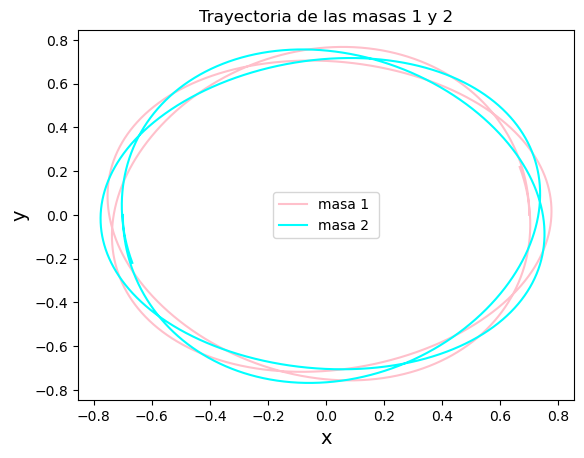

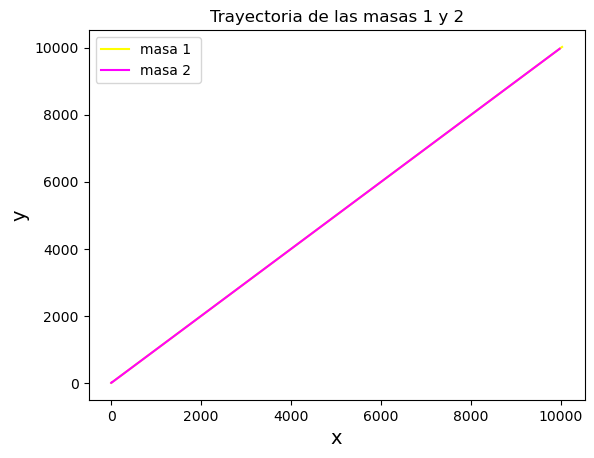

In [54]:
# Condiciones iniciales para que la trayectoria de las masas sea circular (Versión de Diego)

#parametros del sistema resorte
wc = 0.16
wc1=1
l0 = 1

#arreglo que contenga el tiempo con un deltat (h)
tstop = 100
h = 1/100
t=np.arange(0.,tstop+h,h)

# Arreglo con velocidades y posciones iniciales  np.array([x0_1,v0x_1,y0_1,v0y_1,x0_2,v0x_2,y0_2,v0y_2])

u0c=np.array([0.7,0,0,0.1,-0.7,0,0,-0.1]) 
u0c1=np.array([0.1,200,0,200,-0.7,0,0,-0.1])

uc=runge_kutta_4to(resorte,u0c,t,wc,l0)
uc1=runge_kutta_4to(resorte,u0c1,t,wc1,l0)

x1c = uc[:,0]
x2c = uc[:,4]
y1c = uc[:,2]
y2c = uc[:,6]



x1c1 = uc1[:,0]
x2c1 = uc1[:,4]
y1c1 = uc1[:,2]
y2c1 = uc1[:,6]

#Gráfica

plt.plot(x1c,y1c,color="pink", label = "masa 1 ")
plt.plot(x2c,y2c,color="cyan", label = "masa 2")
plt.xlabel('x',fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(loc = 'best')
plt.title("Trayectoria de las masas 1 y 2")
plt.show()


plt.plot(x1c1,y1c1,color="yellow", label = "masa 1 ")
plt.plot(x2c1,y2c1,color="magenta", label = "masa 2")
plt.xlabel('x',fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(loc = 'best')
plt.title("Trayectoria de las masas 1 y 2")
plt.show()

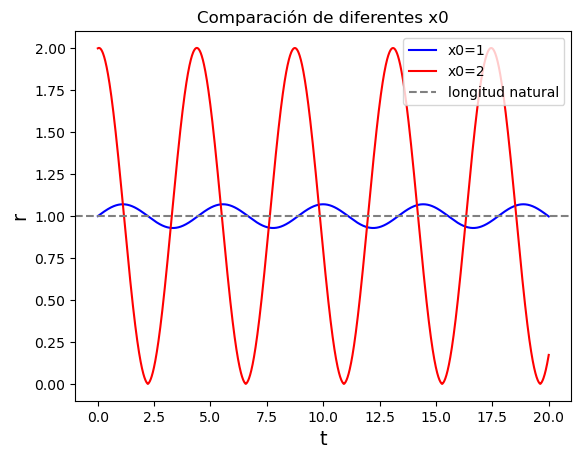

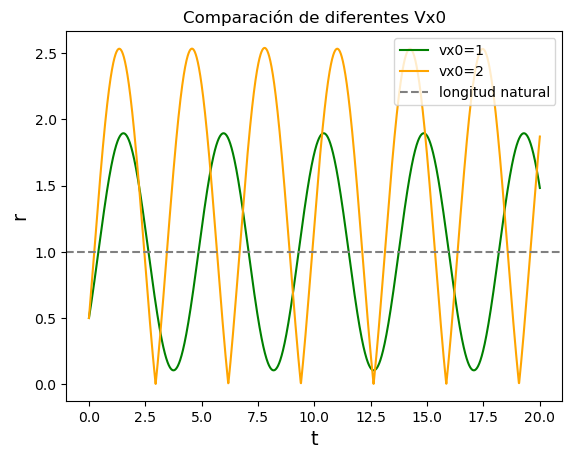

In [55]:
# Condiciones iniciales para que la distancia relativa oscile de manera más asimétrica respecto al equilibrio

#parametros del sistema resorte
w = 1
l0 = 1

#arreglo que contenga el tiempo con un deltat (h)
tstop = 20
h = 1/100
t=np.arange(0.,tstop+h,h)

# Arreglos con diferentes velocidades y posciones iniciales  np.array([x0_1,v0x_1,y0_1,v0y_1,x0_2,v0x_2,y0_2,v0y_2])

u01=np.array([1,0.05,0,0,0,-0.05,0,0]) #x0=1
u02=np.array([2,0.05,0,0,0,-0.05,0,0]) #x0=2

u03=np.array([0.5,1,0,0,0,-0.05,0,0]) #vx0=1
u04=np.array([0.5,2,0,0,0,-0.05,0,0]) #vx0=3

u1=runge_kutta_4to(resorte,u01,t,w,l0)
u2=runge_kutta_4to(resorte,u02,t,w,l0)
u3=runge_kutta_4to(resorte,u03,t,w,l0)
u4=runge_kutta_4to(resorte,u04,t,w,l0)

#Sacamos las r relativas

r1=np.sqrt((u1[:,4]-u1[:,0])**2+(u1[:,6]-u1[:,2])**2)
r2=np.sqrt((u2[:,4]-u2[:,0])**2+(u2[:,6]-u2[:,2])**2)
r3=np.sqrt((u3[:,4]-u3[:,0])**2+(u3[:,6]-u3[:,2])**2)
r4=np.sqrt((u4[:,4]-u4[:,0])**2+(u4[:,6]-u4[:,2])**2)

#Las graficamos en función del tiempo
plt.plot(t,r1, color='blue',label = "x0=1")
plt.plot(t,r2, color='red',label = "x0=2")
plt.axhline(y = l0, color = 'grey', linestyle = 'dashed', label="longitud natural")
plt.xlabel('t',fontsize=14)
plt.ylabel('r', fontsize=14)
plt.legend(loc = 'best')
plt.title("Comparación de diferentes x0")
plt.show()

plt.plot(t,r3, color='green',label = "vx0=1")
plt.plot(t,r4, color='orange',label = "vx0=2")
plt.axhline(y = l0, color = 'grey', linestyle = 'dashed', label="longitud natural")
plt.xlabel('t',fontsize=14)
plt.ylabel('r', fontsize=14)
plt.legend(loc = 'best')
plt.title("Comparación de diferentes Vx0")
plt.show()



# Comparación Runge Kutta vs Burlisch Stoer

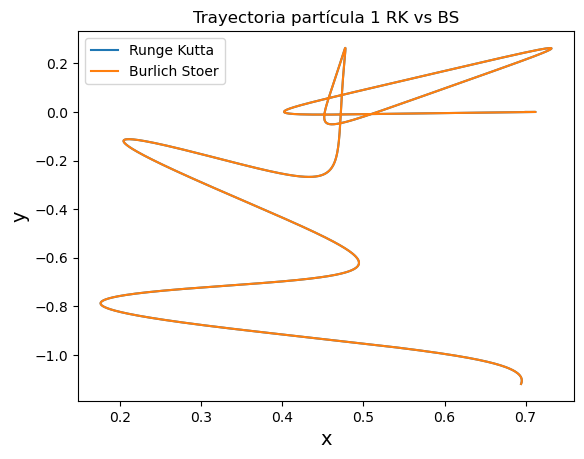

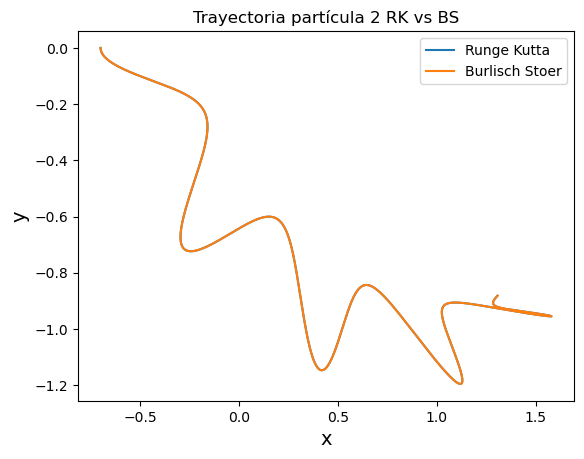

In [56]:

#parametros del sistema resorte
w = 1
l0 = 1

#arreglo que contenga el tiempo con un deltat (h)
tstop = 20
h = 1/100
t=np.arange(0.,tstop+h,h)

#condiciones iniciales de posición
x0_1m3=0.7
y0_1m3=0
x0_2m3=-0.7
y0_2m3=0

v0x_2m3=0
v0x_1m3=0.1
v0y_1m3=0
v0y_2m3=-0.1
#arreglo que contenga las condiciones iniciales: np.array([x0_1,v0x_1,y0_1,v0y_1,x0_2,v0x_2,y0_2,v0y_2])
u0m3 = np.array([x0_1m3,v0x_1m3,y0_1m3,v0y_1m3,x0_2m3,v0x_2m3,y0_2m3,v0y_2m3])

uRK=runge_kutta_4to(resorte,u0m3,t,w,l0)
uBS=BSmultiple(resorte,u0m3,t,0.1,w,l0)

x1rk = uRK[:,0]
x2rk = uRK[:,4]
y1rk = uRK[:,2]
y2rk = uRK[:,6]

x1bs = uBS[:,0]
x2bs = uBS[:,4]
y1bs = uBS[:,2]
y2bs = uBS[:,6]

#Gráficas

plt.plot(x1rk,y1rk, label = "Runge Kutta ")
plt.plot(x1bs,y1bs, label = "Burlich Stoer")
plt.xlabel('x',fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(loc = 'best')
plt.title("Trayectoria partícula 1 RK vs BS")
plt.show()


plt.plot(x2rk,y2rk, label = "Runge Kutta")
plt.plot(x2bs,y2bs, label = "Burlisch Stoer")
plt.xlabel('x',fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(loc = 'best')
plt.title("Trayectoria partícula 2 RK vs BS")
plt.show()